## Introduction:

In this notebook we'll try to understand brain activity relates to external signals, by analysing the results of an experiment where a fish was exposed to a visual stimulus while we recorded its brain activity and tail movements.
As a reminder this is a schematic of the experimental setup:

![setup](https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/img/experimental_setup_danionella.png)

We'll start by looking at correlations with a single external signal, then we'll use multiple linear regression to see how different signals are encoded in the brain and finally we'll try to decode external signals from brain activity.

Some parts are missing and you'll have to code them yourself, they are highlighted with a keyboard symbol ⌨️.

Let's get started by importing the necessary libraries and data.

### Import libraries and dataset:

Download data and helper functions in the workspace:

In [1]:
!mkdir /content/Helper_Functions/
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/accessing_data.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/hmm_plotters.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/OrthoViewer.py
!wget -P /content/Helper_Functions/ https://raw.githubusercontent.com/EmeEmu/IBIO-Banyuls2023-Python/main/Helper_Functions/plotting_functions.py

In [2]:
!gdown --folder 1k21VhLoonOnoxxXyswrmE45VIB4FF00n

Import libraries:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from Helper_Functions.accessing_data import h5tree_view
from ipywidgets import interact
from scipy.signal import convolve
from scipy.interpolate import interp1d
from sklearn.preprocessing import scale
from Helper_Functions.OrthoViewer import OrthoAxes
from Helper_Functions.plotting_functions import plot_dff_traces,plot_dff_raster,plot_brain_layers,plot_brain_projections,plot_coefficients,plot_neurons_per_label
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import r2_score
import itertools
from tqdm import tqdm

Install ipympl to activate interactive plots:

In [ ]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()
#%matplotlib widget

Set resolution of the plots:

In [4]:
plt.rcParams['figure.dpi']=150

Automatically reload modules:

In [5]:
%load_ext autoreload
%autoreload 2

Import the file `fish1_different_speeds.hdf5`, visualize the data tree and save some arrays to local variables:

In [8]:
#⌨️⬇️
file=h5py.File('/content/banyuls_data/fish1_different_speeds.hdf5','r')
h5tree_view(file)

. ../content/banyuls_data/fish1_different_speeds.hdf5
├── 📁brain
│   ├── 🔢coordinates ⚙️(3, 30971)float64
│   ├── 🔢dff ⚙️(30971, 481)float64
│   ├── 🔢times ⚙️(481,)float64
├── 📁stimulus
│   ├── 🔢T ⚙️(481,)float64
│   ├── 🔢direction ⚙️(14362,)float64
│   ├── 🔢speed ⚙️(14362,)float64
│   ├── 🔢times ⚙️(14362,)float64
├── 📁tail
│   ├── 🔢coordinates ⚙️(36107, 11, 2)float64
│   ├── 🔢deflection ⚙️(36107,)float64
│   ├── 🔢forward_thrust ⚙️(36107,)float64
│   ├── 🔢side_thrust ⚙️(36107,)float64
│   ├── 🔢times ⚙️(36107,)float64


In [7]:
#⌨️⬇️
brain_times=file['brain/times'][:]
dff=file['brain/dff'][:]
coords=file['brain/coordinates'][:]

stimulus_speed=file['stimulus/speed'][:]
stimulus_times=file['stimulus/times'][:]
stimulus_T=file['stimulus/T'][:]

tail_times=file['tail/times'][:]
deflection=file['tail/deflection'][:]
forward_thrust=file['tail/forward_thrust'][:]
side_thrust=file['tail/side_thrust'][:]

Remember to close the file:

In [ ]:
#⌨️⬇️
file.close()

## Correlation between neural activity and external signals:

### Preprocessing the signal:

At first we'll try to find neurons whose activity is correlated with tail movements.  Even though the fish is head-immobilized, it can move its tail and we can calculate the strength of such movements.  `forward_thrust` is one such a measure, the higher the value the stronger the force the fish is exerting to try and move forward.

We're going to look for neurons whose activity is correlated with this signal, but first we have to do some preprocessing in order to make it comparable with the fluorescence time series.

We start by plotting `forward_thrust` together with `deflection`, a measure of the deflection of the tail from its resting position:

In order to make the two signals comparable, you can use the function `scale` from sklearn to normalize them.

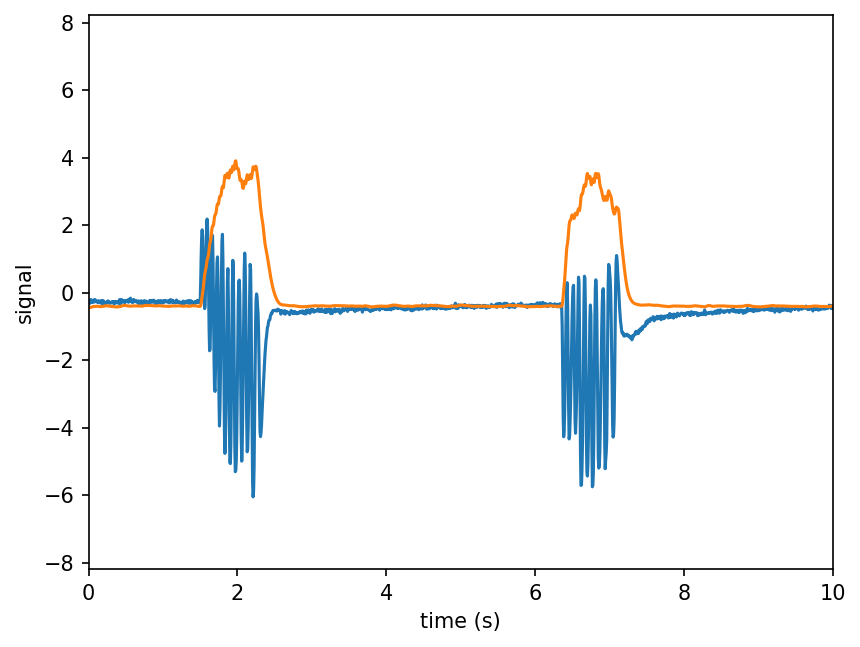

In [ ]:
#⌨️⬇️
t1=0
t2=10 #brain_times[-1]
fig,ax=plt.subplots()
ax.plot(tail_times,scale(deflection))
ax.plot(tail_times,scale(forward_thrust))
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.set_xlim(t1,t2)
plt.show()

As expected we see that `forward_thrust` is zero when the tail is at rest and it becomes positive when the tail oscillates.

The fluorescence that we observe is a indicator of neural activity, it's a measure of the concentration of calcium ions inside the neuron, which in turn is correlated with its firing rate.  Because of the unbinding kinetics of the calcium indicator, the fluorescence decays exponentially following an action potential with a characteristic time of $\tau \simeq 3$ s.

Fluorescence traces can be seen as a convolution of the spike train with a calcium impulse response function, which we'll take to be a simple exponential.

Because of this, if we want to compare our behavioral signal with the fluorescence traces, we'll have to convolve it with an exponential kernel of the form: $H(t) e^{-t/\tau}$

We start by defining the exponential kernel for the convolution, note that $t=0$ has to corresponds to the center of the array and the spacing between two points needs to be the same as for the tail signal:

In [ ]:
#⌨️⬇️
tau=3 #characteristic decay time
kernel_size=10 #size of the kernel in units of tau
dt=np.mean(np.diff(tail_times)) #spacing between successive timepoints
n_points=int(kernel_size*tau/dt)
kernel_times=np.linspace(-n_points*dt,n_points*dt,2*n_points+1) #linearly spaced array from -n_points*dt to n_points*dt with spacing dt
kernel=np.exp(-kernel_times/tau) #define kernel as exponential decay
kernel[kernel_times<0]=0 #set to zero for negative times

Let's plot it to check that we implemented it properly:

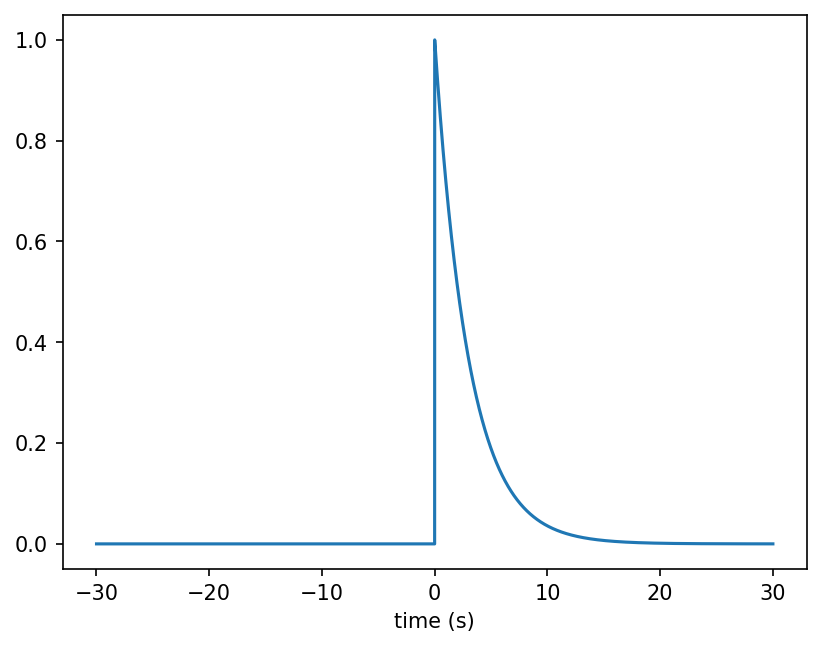

In [ ]:
fig,ax=plt.subplots()
ax.plot(kernel_times,kernel)
ax.set_xlabel('time (s)')
plt.show()

Now we can perform the convolution, we can use the function `convolve` from scipy, which perform a discrete convolution, we're trying to approximate a continuous convolution so we have to multiply it by the time increment in between two points: 

In [ ]:
#⌨️⬇️
forward_thrust_conv=convolve(forward_thrust,kernel,mode='same')*dt

Let's have a look at the original signal together with the convolved one:: 

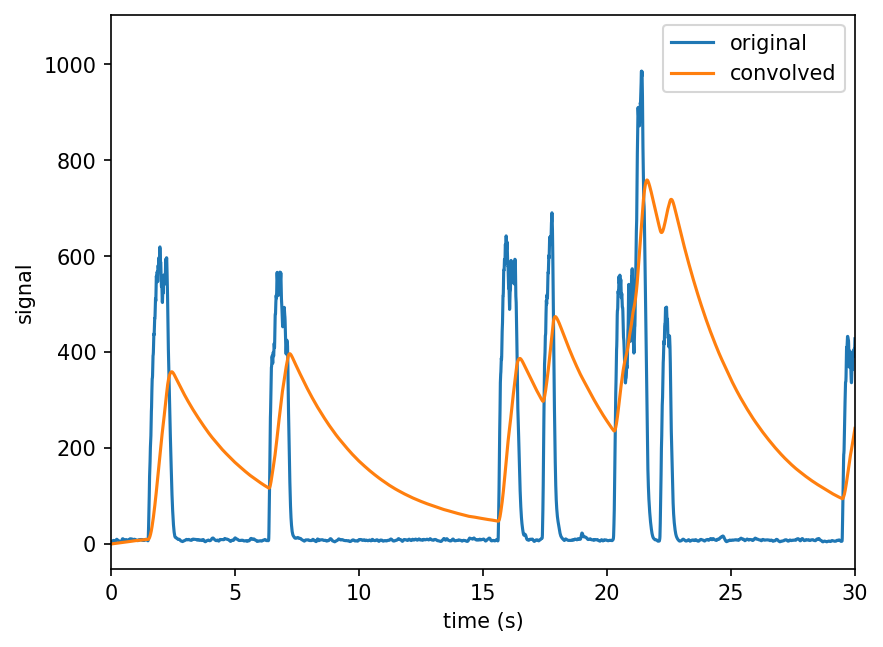

In [ ]:
#⌨️⬇️
t1=0
t2=30 #brain_times[-1]
fig,ax=plt.subplots()
ax.plot(tail_times,forward_thrust,label='original')
ax.plot(tail_times,forward_thrust_conv,label='convolved')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

Now we can in principle compare this signal with the neural activity, but if you look at the shape of `forward_thrust_conv` and `dff` you'll notice that there are many more timepoints in the tail signal. This is because the tail images were acquired at a much higher frame rate.  In order to compare the to time series we have to downsample the tail signal so that it is evaluated at the same times as the neural activities.

To do so we'll perform a linear interpolation which basically means connecting the dots in our plot with straight lines (something that matplotlib already does by default when we're visualizing it). You can use the function `interp1d` from scipy to perform the interpolation, it returns a function that you can then evaluate on the times at which the fluorescence was measured:

In [ ]:
#⌨️⬇️
forward_thrust_conv_interp_f=interp1d(tail_times,forward_thrust_conv,kind='linear',fill_value='extrapolate')
signal_forward=forward_thrust_conv_interp_f(brain_times)

Let's check the results by plotting the original signal together with the downsampled one (change the marker option in the plotting function to see the single unconnected datapoints):

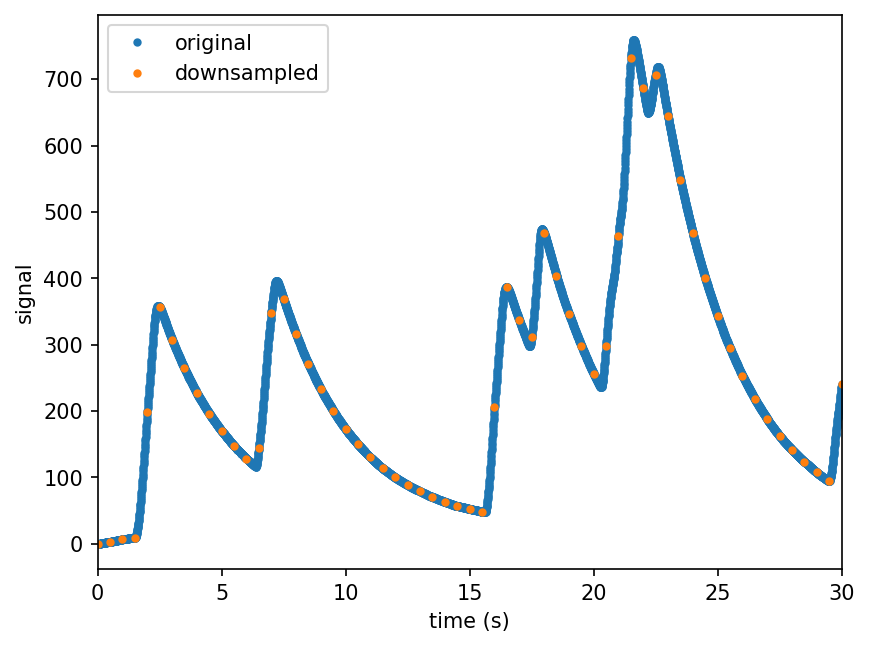

In [ ]:
#⌨️⬇️
t1=0
t2=30 #brain_times[-1]
fig,ax=plt.subplots()
ax.plot(tail_times,forward_thrust_conv,'.',label='original')
ax.plot(brain_times,signal_forward,'.',label='downsampled')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

We can define a function that does all this in once to make this preprocessing easier in the future:

In [ ]:
def convolve_and_interpolate(signal,signal_times,output_times,tau=3,kernel_size=10):
    """Convolve signal with the calcium impulse response function and resample it at different times using linear interpolation.

    Parameters :
    ------------
    signal : 1d array
        values of the time series
        
    signal_times : 1d array
        timepoints of the time series

    output_times : 1d array
        timepoints at which we want to resample the signal
    
    tau : integer
        characteristic decay time of the exponential kernel in seconds
        default : 3
    
    kernel_size : integer
        size of the kernel in units of tau
        default : 10  
        
    Return :
    --------
    signal_conv_interp : 1d array
        resampled values of the convolved time series
    """
    #⌨️⬇️
    dt=np.mean(np.diff(signal_times)) #spacing between successive timepoints
    n_points=int(kernel_size*tau/dt)
    kernel_times=np.linspace(-n_points*dt,n_points*dt,2*n_points+1) #linearly spaced array from -n_points*dt to n_points*dt with spacing dt
    kernel=np.exp(-kernel_times/tau) #define kernel as exponential decay
    kernel[kernel_times<0]=0 #set to zero for negative times
    
    signal_conv=convolve(signal,kernel,mode='same')*dt #perform the convolution
    signal_conv_interp_f=interp1d(signal_times,signal_conv,kind='linear',fill_value='extrapolate') #linear interpolation
    signal_conv_interp=signal_conv_interp_f(output_times) #resampling
    return signal_conv_interp

### Calculating correlations:

As a measure of correlation we can calculate the covariance between the preprocessed swimming strength and the neural fluorescence traces.  

$$Cov(x,y)=\overline{(x-\bar{x})\cdot(y-\bar{y})}$$

Regions where both signals are larger or smaller than their averages give positive contibutions, whereas regions where one is larger and the other is smaller give negative contributions.  This way correlated signals we'll have a positive covariance, anticorrelated signals a negative covariance, and uncorrelated signals a covariance that is close to zero (how much?).

Let's write a function that gives us the covariance values between some signal and every single neural activity trace:

In [ ]:
def calculate_covariance(signal,dff):
    """Calculate covariance values between signal and rescaled fluorescence for all neurons.

    Parameters :
    ------------
    signal : 1d array
        external signal, shape (n_timepoints)
        
    dff : 2d array
        rescaled fluorescence traces for all neurons, shape (n_neurons,n_timepoints)
        
    Return :
    --------
    covariance : 1d array
        covariance values
    """
    #⌨️⬇️
    n_neurons=len(dff)
    signal_centered=signal-np.mean(signal) #subtract the average from the signal
    dff_centered=dff-np.mean(dff,axis=1)[:,np.newaxis] #subtract the average from every fluorescence trace
    covariance=np.zeros(n_neurons)
    for i in range(n_neurons): #loop over all neurons
        covariance[i]=np.mean(signal_centered*dff_centered[i]) #evaluate the covariance
    
    return covariance

Now we can evaluate the covariances with the swimming strength:

In [ ]:
#⌨️⬇️
covariance_forward=calculate_covariance(signal_forward,dff)

And visualize the results by plotting a histogram of the covariance values:

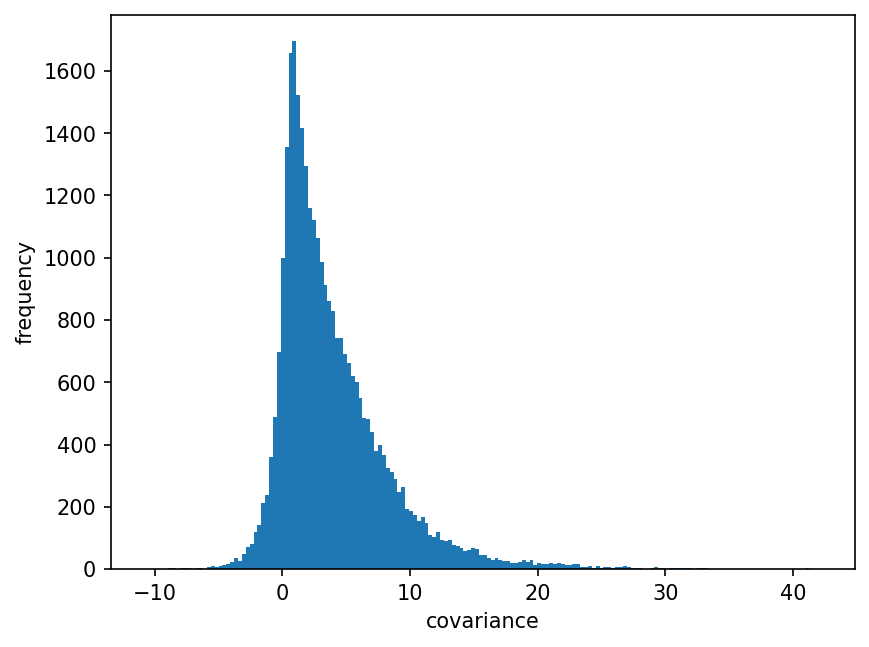

In [ ]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(covariance_forward,bins='auto')
ax.set_xlabel('covariance')
ax.set_ylabel('frequency')
plt.show()

### Calculating statistical significance:

How do we know if a covariance value is significantly larger than zero?
We need a way to define a threshold above which covariances are statistically significant.

We would like to know the distribution of covariances in the case where the two signals are uncorrelated.
We can estimate it with a method called bootstrapping, it consists in resampling our signal in order to create new signals with the same statistics.
As we're working with time series, adjacent samples are not independent but correlated in time, thus we're going to resample blocks of consecutive samples in order to preserve the structure on short times.

We choose a method called stationary bootstrap, in which the size of the blocks is randomized as well.

It's might be a bit complicated, you can try to code it yourself but if you don't manage just have a look at it and try understand how it works.  We want to create a new signal by sampling blocks of the original signal with a length that is sampled from a geometric distribution.  In practice this is equivalent to choosing as first value of our new array a random value of the original array and then for each successive value we either take the successive value in the original array with probability $1-p$, or a new random value with probability $p$.  If we reach the end of the original array then we consider the first value as the succesive one.  $p$ is a parameter of the geometric distribution and it turns out that it's the inverse of the average size of the blocks.

In [ ]:
def stationary_bootstrap(signal,average_block_size=240):
    """resample a time series using stationary bootstrap, it samples with replacement random blocks of sizes following a geometric distribution.

    Parameters :
    ------------
    signal : array
        original time series, the first dimension corresponds to time, shape (n_timepoints,...)
        
    average_block_size : integer
        average number of values in a block during resampling
        default : 240
        
    Return :
    --------
    resampled_signal : array
        bootstrapped time series
    """
    #⌨️⬇️
    l=len(signal)
    p=1/average_block_size #probability of choosing a new random value 
    resampled_signal=np.zeros_like(signal)
    j=np.random.randint(l) #index of the first random value 
    resampled_signal[0]=signal[j] #assign the first random value
    for i in range(1,l): #loop over the next positions in the new array
        if np.random.random()<1-p: #sample a random number to choose in between the two options
            j=(j+1)%l #take the next index
        else:
            j=np.random.randint(l) #take a random index
        resampled_signal[i]=signal[j] #assign the value to the new array
    return resampled_signal

Now let's have a look at some resulting bootstrapped signals, try and tune the average duration of the blocks and see if you obtain the expected results:

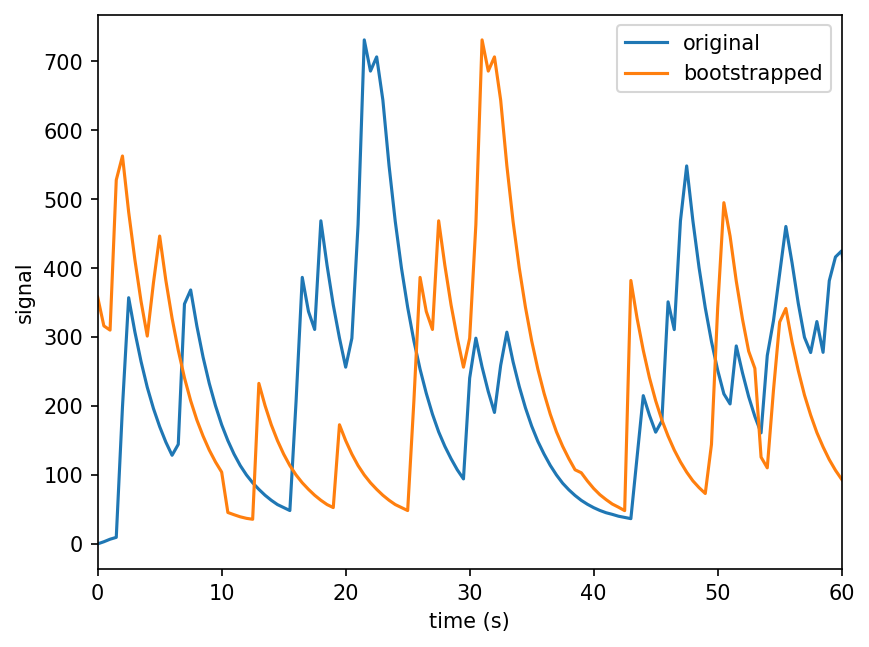

In [ ]:
#⌨️⬇️
average_block_duration=5
dt=np.mean(np.diff(brain_times))
signal_forward_resampled=stationary_bootstrap(signal_forward,average_block_duration/dt)
t1=0
t2=60 #brain_times[-1]
fig,ax=plt.subplots()
ax.plot(brain_times,signal_forward,label='original')
ax.plot(brain_times,signal_forward_resampled,label='bootstrapped')
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.set_xlim(t1,t2)
ax.legend()
plt.show()

Now we can create a null distribution of covariances using the bootstrapped signals, we expect the covariance to follow this distribution for neural activity that is independent of the behavioral signal:

We have to define a function that creates some bootstrapped signals and calculates their covariances with the neural activity:

In [ ]:
def calculate_covariance_bootstrap(signal,dff,n_resamples=50,average_block_size=240):
    """Calculate covariance values between resampled signal using stationary bootstrap and rescaled fluorescence for all neurons.

    Parameters :
    ------------
    signal : 1d array
        external signal, shape (n_timepoints)
        
    dff : 2d array
        rescaled fluorescence traces for all neurons, shape (n_neurons,n_timepoints)
    
    n_resamples: integer
        number of resampled signals used for calculating covariance
        default : 50
        
    average_block_size : integer
        average number of values in a block during resampling
        default : 240
        
    Return :
    --------
    covariance_bootstrap : 1d array
        bootstrapped covariance values, shape (n_resamples*n_neurons)
    """
    #⌨️⬇️
    n_neurons=len(dff)
    covariance_bootstrap=np.zeros(n_resamples*n_neurons) 
    
    for i in tqdm(range(n_resamples)):
        signal_resampled=stationary_bootstrap(signal,average_block_size) #sample a bootstrapped time series
        covariance_bootstrap[i*n_neurons:(i+1)*n_neurons]=calculate_covariance(signal_resampled,dff) #calculate covariances with neural traces
        
    return covariance_bootstrap

Now let's use this function to get the covariance values and compare their distribution with the one of the covariances with the original signal by plotting them together.
You'll have to use the `density` parameter while plotting in order to normalize the two histograms and make them comparable: 

In [ ]:
#⌨️⬇️
covariance_forward_bootstrap=calculate_covariance_bootstrap(signal_forward,dff)

100%|███████████████████████████████████████████| 50/50 [00:31<00:00,  1.60it/s]


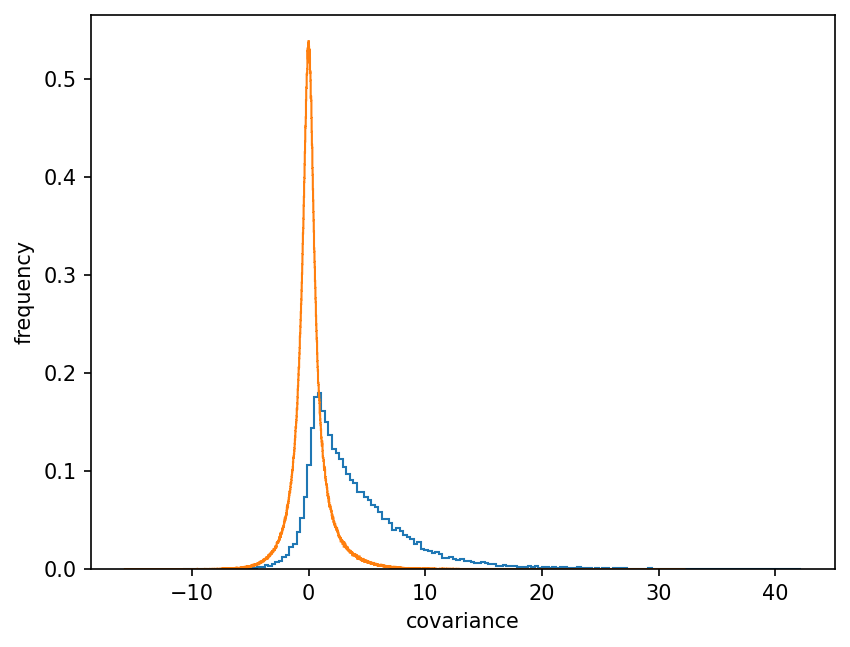

In [ ]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(covariance_forward,bins='auto',histtype='step',density=True,label='original')
ax.hist(covariance_forward_bootstrap,bins='auto',histtype='step',density=True,label='bootstrapped')
ax.set_xlabel('covariance')
ax.set_ylabel('frequency')
plt.show()

What can you say by looking at the two distributions?

Now that we have an estimate of the null distribution, we can calculate the p-value associated to a certain covariance, it's the probability of obtaining an even larger value of covariance according to the null distribution.

We first have to create the empirical distribution function with the boostrapped covariances to approximate the null distribution, then we can evaluate it on the original covariances to calculate the corresponding p-values:

In [ ]:
def calculate_pvalue(statistic,statistic_bootstrap):
    """Calculate p-values for a set of statistics, based on a null distribution estimated with a set of bootstrapped statistics.

    Parameters :
    ------------
    statistic : 1d array
        values of a statistic for which we want to calculate the p-value
        
    statistic_bootstrap : 1d array
        bootstrapped values of a statistic from which we estimated the null distribution
        
    Return :
    --------
    pvalue : 1d array
        p-values
    """
    #⌨️⬇️
    statistic_bootstrap=statistic_bootstrap.ravel() #flatten array in case it's not already one-dimensional
    statistic_bootstrap_sorted=np.sort(statistic_bootstrap) #sort the values in increasing order
    statistic_bootstrap_sorted=np.append(statistic_bootstrap_sorted,statistic_bootstrap_sorted[-1])
    probability_of_smaller_values=np.arange(len(statistic_bootstrap_sorted))/(len(statistic_bootstrap_sorted)-1) #express the probability of finding a smaller value of the statistic
    empirical_distribution_function=interp1d(statistic_bootstrap_sorted,probability_of_smaller_values,kind='next',fill_value='extrapolate') #interpolate to get the eCDF
    pvalue=np.zeros(len(statistic))
    for i in range(len(statistic)):
        pvalue[i]=1-empirical_distribution_function(statistic[i]) #probability of finding a larger value according to the null distribution
        
    return pvalue

Let's calculate the p-values and visualize their distribution:

In [27]:
#⌨️⬇️
pvalue=calculate_pvalue(covariance_forward,covariance_forward_bootstrap)

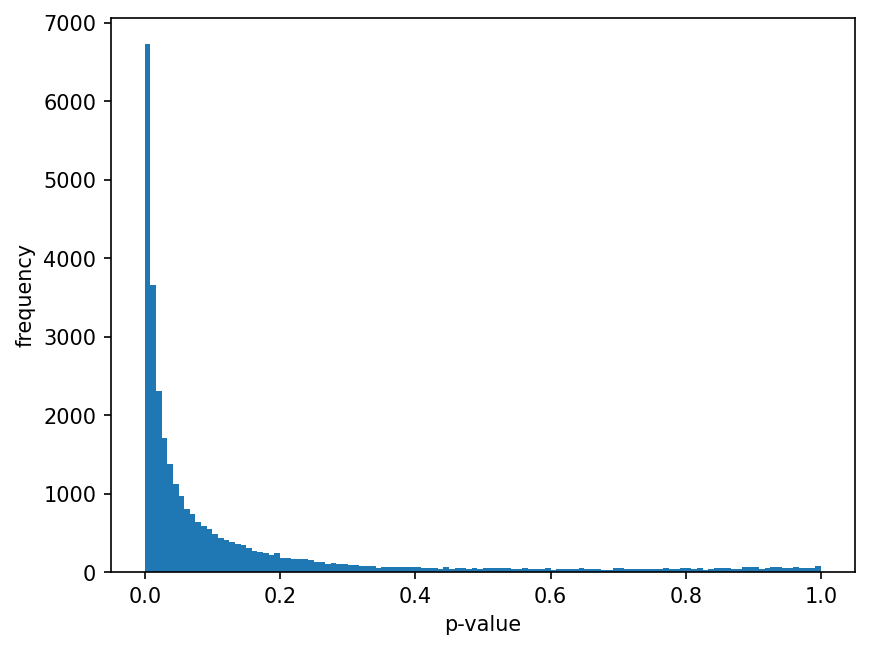

In [28]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(pvalue,bins='auto')
ax.set_xlabel('p-value')
ax.set_ylabel('frequency')
plt.show()

Normally, one would consider as statistically significant a covariance value for which the p-value is smaller than a certain threshold fixed before the experiment.  This would be ok for a single neuron, but in our case we have to be more careful as we're testing multiple hypothesis simultaneously.

What we can do is to control the false discovery rate, expected fraction of false positives, neurons that are incorrectly classified as significantly correlated.  We can implement the Benjamini–Hochberg procedure, which ensures that the false discovery rate is smaller than a given threshold $\alpha$.  If we're testing $m$ hypotheses we have to sort the p-values in increasing order and find the largest index $k$ such that $P_k \leq \frac{k}{m}\alpha$.  Then we  can reject the null hypothesis of uncorrelated signals for the $k$ neurons with the smallest p-values.

We can understand this procedure visually by plotting the p-values sorted with increasing order together with a line with slope $\alpha/m$. Then we find the largest p-value that is below this line and we can reject the null hypothesis for all neurons whose p-values is smaller or equal to that one.

Let's try to plot both the p-values and the Benjamini-Hochberg line as a function of the index:

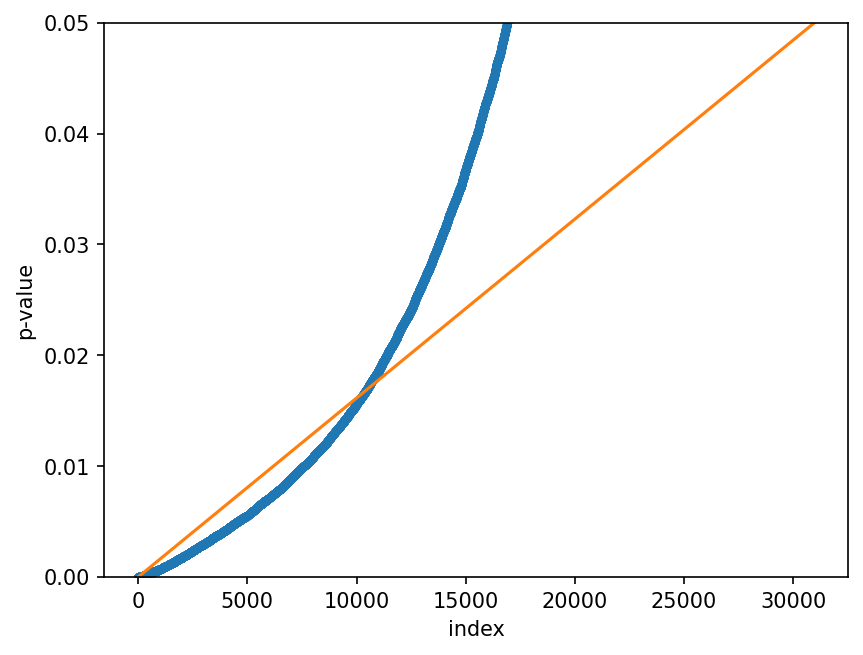

In [29]:
#⌨️⬇️
alpha_bh=0.05
n_neurons=len(pvalue)
indices=np.arange(n_neurons)+1
sorted_pvalues=np.sort(pvalue)
line_bh=indices/n_neurons*alpha_bh

fig,ax=plt.subplots()
ax.plot(sorted_pvalues,'.')
ax.plot(line_bh)
ax.set_ylim(0,alpha_bh)
ax.set_xlabel('index')
ax.set_ylabel('p-value')
plt.show()

We can use this to extract the indices of the significantly correlated neurons:

In [30]:
def find_significant_neurons(statistic,statistic_bootstrap,alpha_bh=0.05):
    """Calculate p-values and test if they are significant using the Benjamini-Hochberg procedure.

    Parameters :
    ------------
    statistic : 1d array
        values of the statistic for which we obtained the p-values

    statistic_bootstrap : 1d array
        bootstrapped values of a statistic from which we estimated the null distribution
        
    alpha_bh : float
        threshold on the false discovery rate
        default : 0.05
        
    Return :
    --------
    indices_thr : 1d array
        indices of neurons for which we reject the null hypothesis sorted with decreasing value of the statistic    

    mask : 1d array
        boolean array which gives True on the indices of neurons for which we reject the null hypothesis
    """
    #⌨️⬇️
    pvalue=calculate_pvalue(statistic,statistic_bootstrap)
    
    n_neurons=len(pvalue)
    indices=np.arange(n_neurons)+1
    sorted_pvalues=np.sort(pvalue)
    line_bh=indices/n_neurons*alpha_bh

    indices_inequality=np.where(sorted_pvalues<=line_bh)[0] #find all indices for which the p-value is below the line
    if len(indices_inequality)==0:
        n_significant_neurons=0
    else:
        n_significant_neurons=np.max(indices_inequality)+1 #largest index

    indices_sorted=np.argsort(-statistic) #sort indices with decreasing value of the statistic
    indices_thr=indices_sorted[:n_significant_neurons] #only take the ones for which the statistic is significantly larger than zero
    mask=np.zeros(len(dff)) #create a mask for the neurons for which we reject the null hypothesis
    mask[indices_thr]=1
    mask=mask.astype(bool)

    return indices_thr,mask

And let's see how many neurons are significantly correlated with the swimming strength:

In [31]:
#⌨️⬇️
indices_forward,mask_forward=find_significant_neurons(covariance_forward,covariance_forward_bootstrap)
len(indices_forward)

10470

### Plotting activity and position of significantly correlated neurons:

Now we can plot the fluorescence traces of the significantly correlated neurons together with the behavioral signal:

In [32]:
#⌨️⬇️
plot_dff_traces(signal_forward,brain_times,indices_forward,dff)

interactive(children=(IntSlider(value=0, description='neuron', max=10469), Output()), _dom_classes=('widget-in…

What can you tell by looking at the activity traces?  Is there something wrong?  What do you think the problem is? 

We can also look at all the fluorescence traces together by encoding them in the lightness values of the pixels in an image, the result is called a raster plot:

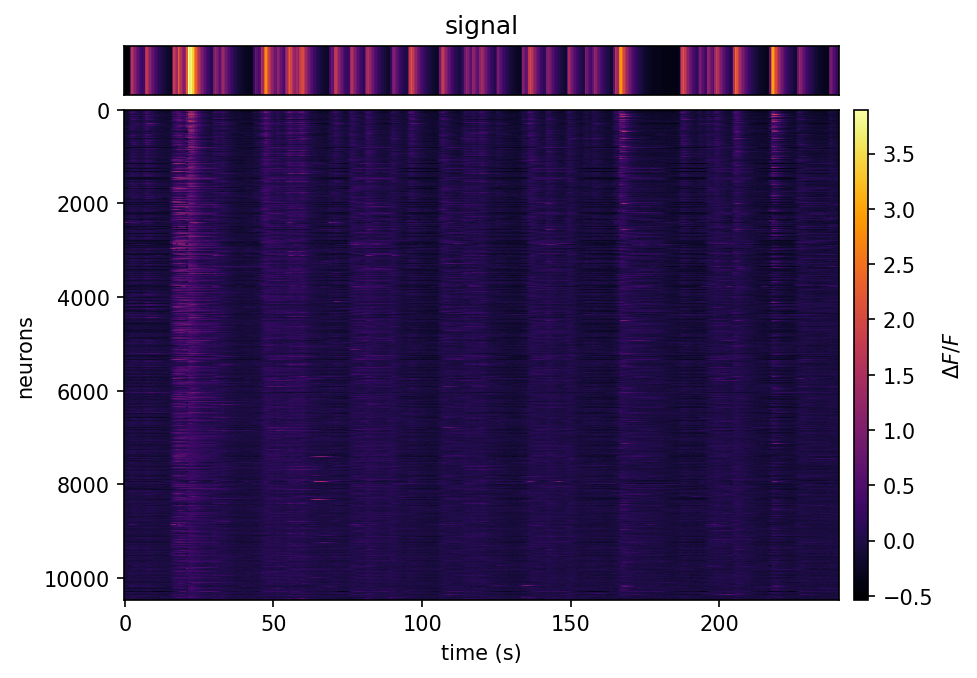

In [33]:
#⌨️⬇️
plot_dff_raster(signal_forward,brain_times,indices_forward,dff)

We can plot the positions of the neurons that are significantly correlated, with the opacity of the points proportional to the covariance:

In [34]:
#⌨️⬇️
plot_brain_layers(coords,covariance_forward,mask_forward)

interactive(children=(IntSlider(value=0, description='layer', max=19), Output()), _dom_classes=('widget-intera…

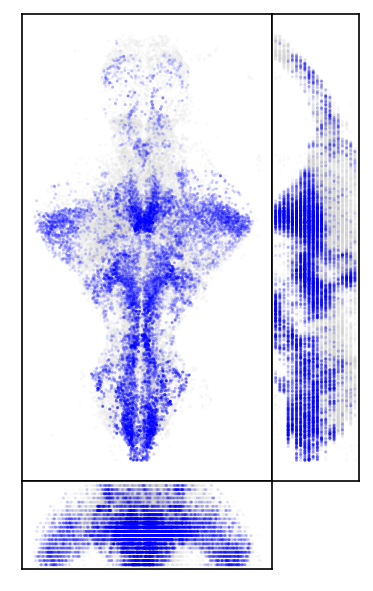

In [35]:
#⌨️⬇️
plot_brain_projections(coords,covariance_forward,mask_forward)

We can also look at the activity of these neurons as a function of the swimming strength:

To do so we have to discretize the range of values of the swimming strength (using `histogram_bin_edges` from numpy) and then calculate the average activity of these neurons when the swimming strength values fall in each of the bins.

In [36]:
def calculate_average_dff(signal,dff,indices,n_bins=10):
    """Calculate average activity of certain neurons as a function of the signal values.

    Parameters :
    ------------
    signal : 1d array
        external signal, shape (n_timepoints)
        
    dff : 2d array
        rescaled fluorescence traces for all neurons, shape (n_neurons,n_timepoints)
        
    indices : 1d array
        indices of neurons over which we want to average
        
    Return :
    --------
    bin_centers : 1d array
        values of signal at the center of each bin  

    dff_mean : 1d array
        average dff of indexed neurons for the signal in each of the bins
        
    dff_mean : 1d array
        standard deviation of the dff values of indexed neurons for the signal in each of the bins
    """
    #⌨️⬇️
    bin_edges=np.histogram_bin_edges(signal,n_bins)
    bin_centers=(bin_edges[1:]+bin_edges[:-1])/2
    
    dff_mean=np.zeros(n_bins)
    dff_std=np.zeros(n_bins)

    for i in range(n_bins):
        dff_mean[i]=dff[indices][:,(signal>bin_edges[i])&(signal<bin_edges[i+1])].mean()
        dff_std[i]=dff[indices][:,(signal>bin_edges[i])&(signal<bin_edges[i+1])].std()

    return bin_centers,dff_mean,dff_std

Evaluate the average activity and plot it as a function of the swimming strength.  You can use the function `errorbar` from matplotlib to show the standard deviations together with the averages:

In [37]:
#⌨️⬇️
bin_centers,dff_mean,dff_std=calculate_average_dff(signal_forward,dff,indices_forward)

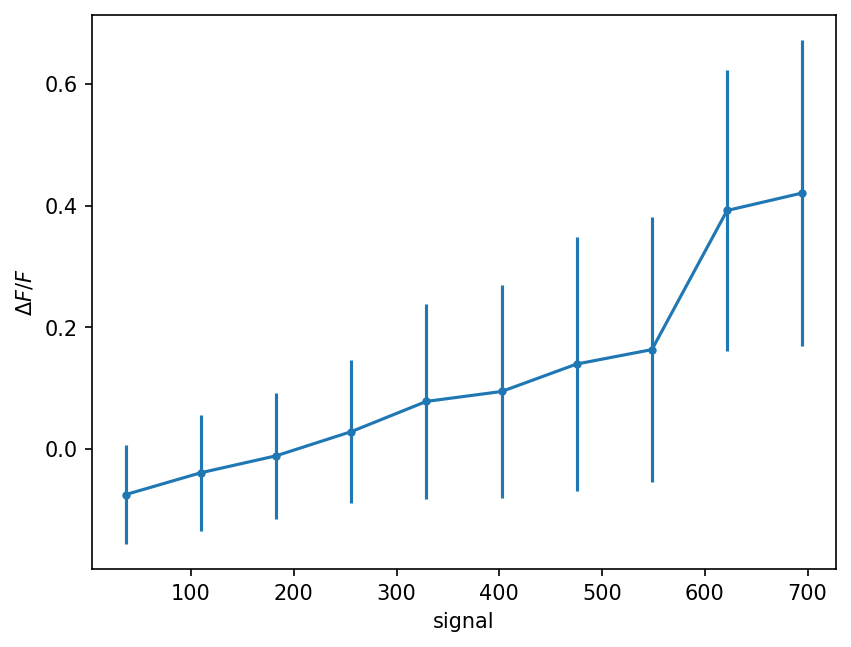

In [38]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.errorbar(bin_centers,dff_mean,dff_std,fmt='.-')
ax.set_xlabel('signal')
ax.set_ylabel(r'$\Delta F/F$')
plt.show()

### Correlation with stimulus speed:

After all this work we can easily look for neurons whose activity is correlated with the speed of the external stimulus.

Let's start by preprocessing the signal and visualizing it:

In [39]:
#⌨️⬇️
signal_speed=convolve_and_interpolate(stimulus_speed,stimulus_times,brain_times)

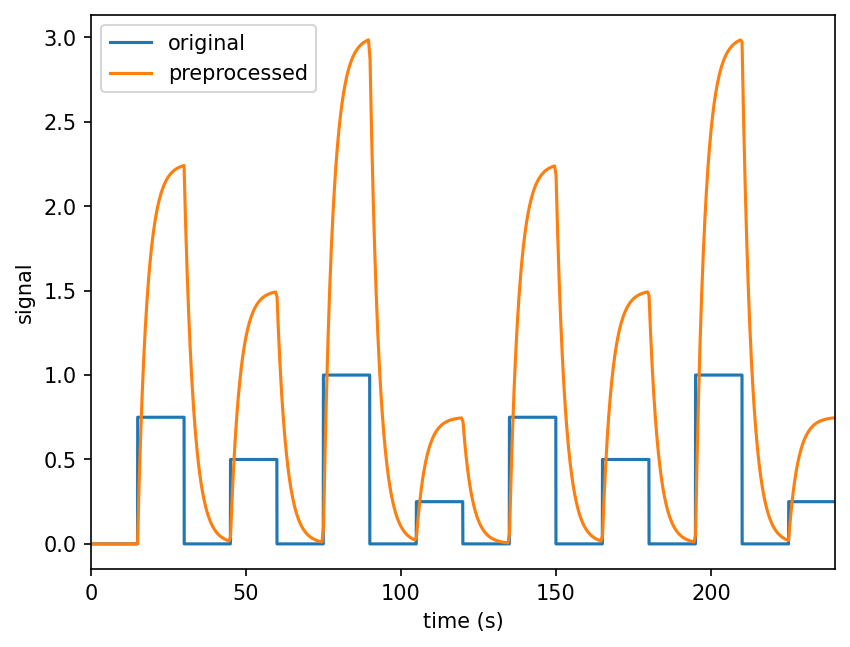

In [40]:
#⌨️⬇️
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
ax.plot(stimulus_times,stimulus_speed,label='original')
ax.plot(brain_times,signal_speed,label='preprocessed')
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

Then let's calculate the covariances and find the neurons for which they are significantly larger than zero:

In [41]:
#⌨️⬇️
covariance_speed=calculate_covariance(signal_speed,dff)
covariance_speed_bootstrap=calculate_covariance_bootstrap(signal_speed,dff)

100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  3.88it/s]


In [42]:
indices_speed,mask_speed=find_significant_neurons(covariance_speed,covariance_speed_bootstrap)
len(indices_speed)

1499

And finally let's look at their activity and position:

In [43]:
#⌨️⬇️
plot_dff_traces(signal_speed,brain_times,indices_speed,dff)

interactive(children=(IntSlider(value=0, description='neuron', max=1498), Output()), _dom_classes=('widget-int…

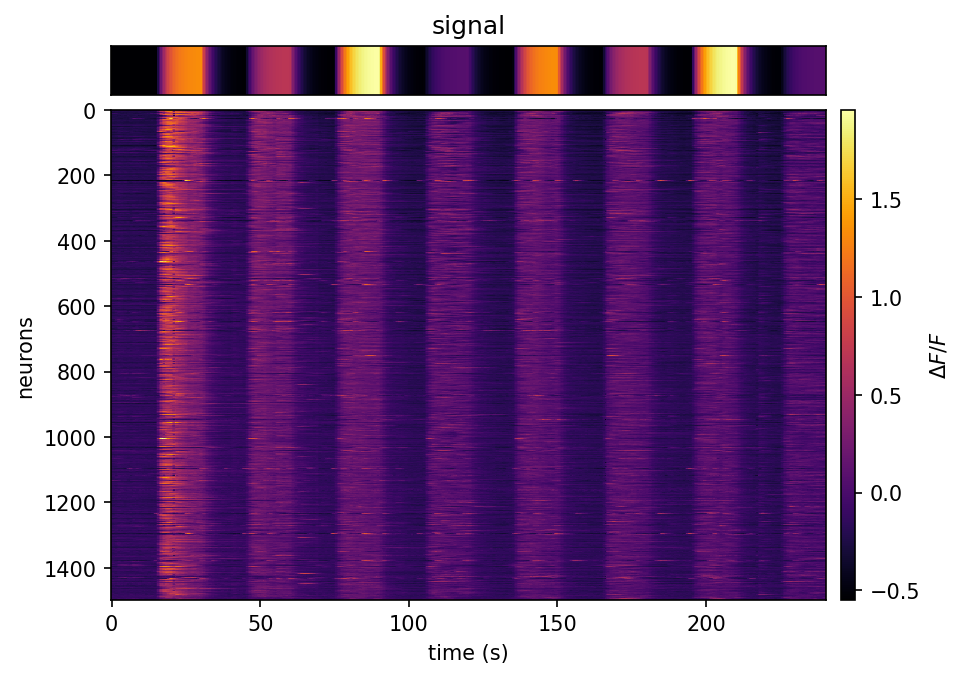

In [44]:
#⌨️⬇️
plot_dff_raster(signal_speed,brain_times,indices_speed,dff)

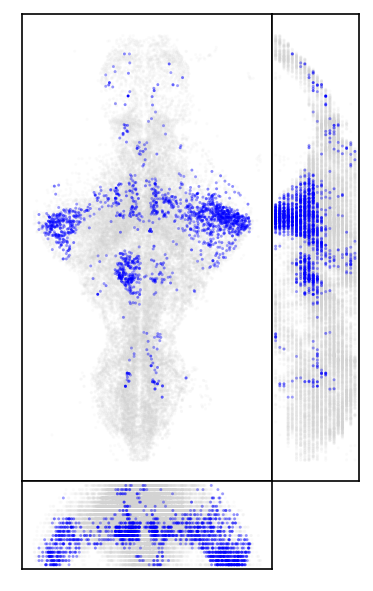

In [45]:
#⌨️⬇️
plot_brain_projections(coords,covariance_speed,mask_speed)

Have a look at the results, are they as you expected? Is there something strange?

Now if you have time you can try and analyze correlations with other signals that you think might be interesting, otherwise let's move on to the next section!

## Multiple linear regression:

We've seen how to find neurons whose activity is correlated with a single signal, for example some feature of a behavior or of an external stimulus.

But what about neurons that encode multiple different signal?

We can use multiple linear regression to find how different external signals are encoded in the brain.

We're going to fit neural activity independently for each neuron with a linear combination of such signals, called regressors.

### Define regressors:

We've seen that most neurons correlated with stimulus speed have a strong activation on the first trial.

We can try to find how different neurons encode the surprise of the first unexpected trial, the presence of the stimulus and its speed, by defining three different regressor: one that is only active on the first trial, one active on all trials and one proportional to the speed of the stimulus.

In [46]:
#⌨️⬇️
signal_speed=convolve_and_interpolate(stimulus_speed,stimulus_times,brain_times)

stimulus=np.copy(stimulus_speed)
stimulus[stimulus_speed>0]=1
signal_stimulus=convolve_and_interpolate(stimulus,stimulus_times,brain_times)

first_trial=np.copy(stimulus_speed)
first_trial[stimulus_times>30]=0
signal_first_trial=convolve_and_interpolate(first_trial,stimulus_times,brain_times)

Now we can create an array containing all the regressors and visualize them. Be careful to normalize the three regressors so that we can better compare their relevance:

In [47]:
#⌨️⬇️
regressors=np.array([scale(signal_speed),scale(signal_stimulus),scale(signal_first_trial)])
#regressors=np.array([scale(signal_forward),scale(signal_left),scale(signal_right)])
#regressors=np.array([scale(signal_left),scale(signal_right)])
#regressors=np.array([scale(signal_forward),scale(signal_stimulus)])
#regressors=np.array([scale(signal_forward),scale(signal_left),scale(signal_right),scale(signal_speed),scale(signal_stimulus),scale(signal_first_trial)])
#regressors=np.array([scale(signal_forward)])

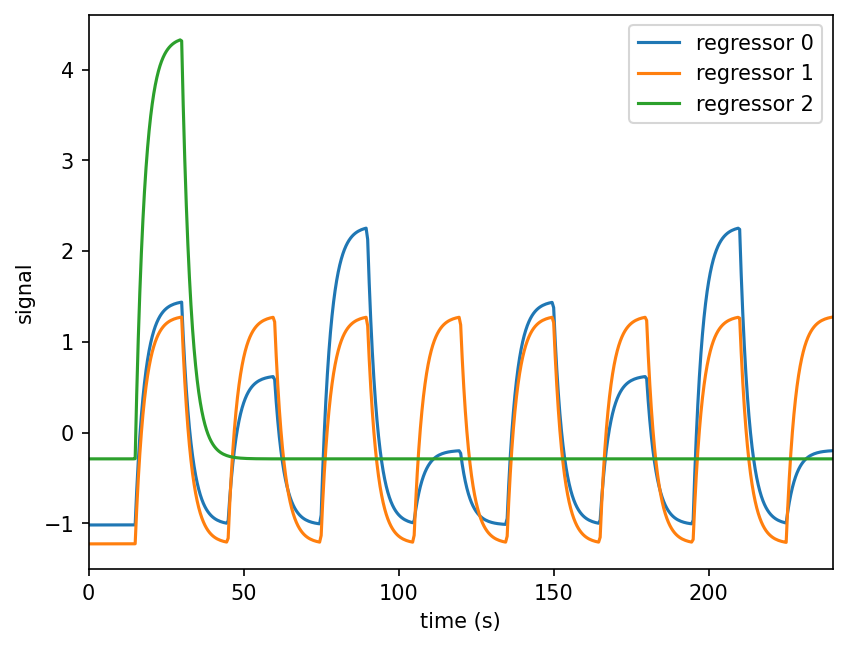

In [48]:
#⌨️⬇️
n_regressors=len(regressors)

t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
for i,regressor in enumerate(regressors):
    ax.plot(brain_times,regressor,label='regressor '+str(i))
    
ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

### Fit the model:

For each neuron $n$ we assume that the fluorescence $y_n(t)$ can be expressed as a linear combination of the regressors $x_i(t)$ with certain coefficients $\beta_{n,i}$ and some additional noise $\epsilon(t)$:

$$ y_n(t) = \sum_{i} \beta_{n,i} x_i(t) + \epsilon(t)$$

Then the coefficients of best fit $\hat \beta_{n,i}$ are those for which the squared error $\sum_{t} (y_n(t)- \sum_{i} \beta_{n,i} x_i(t))^2$ is minimized.

We can get them by using the `LinearRegression` class from the scikit-learn library.  

Be careful about the shape of the arrays, you might have to consider the transposed arrays by using `.T`, which inverts the order of the indices.

In [49]:
#⌨️⬇️
reg=LinearRegression().fit(regressors.T,dff.T)
coef=reg.coef_

And then we can look at the values of the coefficients for the three regressors across the brain by plotting the neurons with a colormap that encodes positive values in red and negative ones in blue:

In [50]:
#⌨️⬇️
plot_coefficients(coords,coef)

interactive(children=(IntSlider(value=0, description='regressor', max=2), Output()), _dom_classes=('widget-int…

We can look at the distribution of the coefficients using histograms:

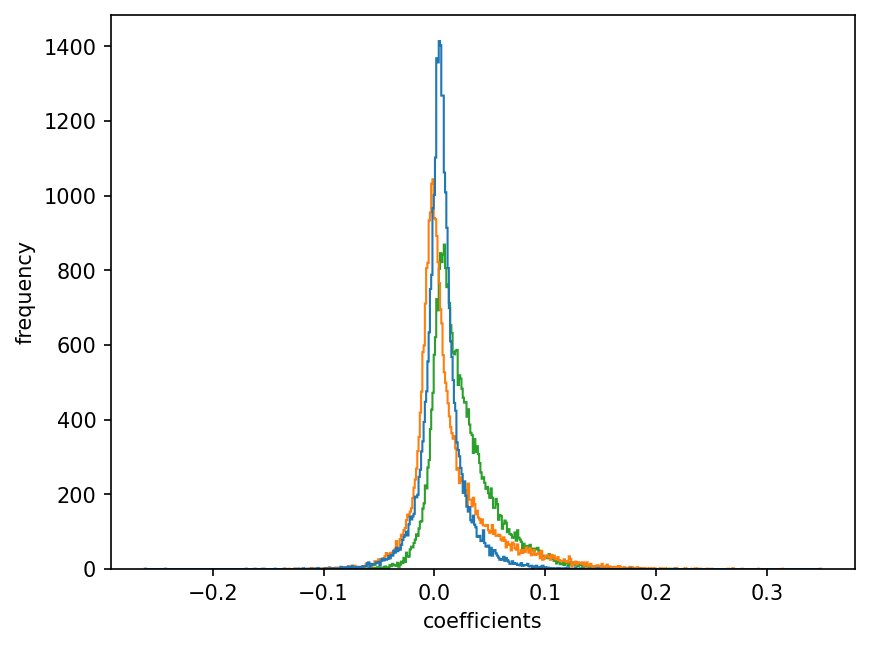

In [51]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(coef,bins='auto',histtype='step')
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

### Find neurons for which the fit is significantly good:

Now we can evaluate the coefficients of determination $R^2$ for each neuron, they're a meausure of how good the fit is.  

$R^2$ is defined as the fraction of variance in the neural activity that is captured by our linear model:

$$ R^2_n = 1 - \frac{\sum_{t}(y_n-\sum_{i} \hat \beta_{n,i} x_i)^2}{\sum_{t}(y_n-\bar y_n)^2} $$

You can use the function `r2_score` to compute the scores. Note that you can use the method `predict()` to obtain the fluorescence values $y_n$ predicted by the linear model for certain values of the independent variables $x_i$.  And be careful about the value of the `multioutput` parameter.

In [52]:
#⌨️⬇️
r2=r2_score(dff.T,reg.predict(regressors.T),multioutput='raw_values')

And we look at their distribution in the brain, we can choose a power of $R^2$ for the opacity in order to increase the contrast:

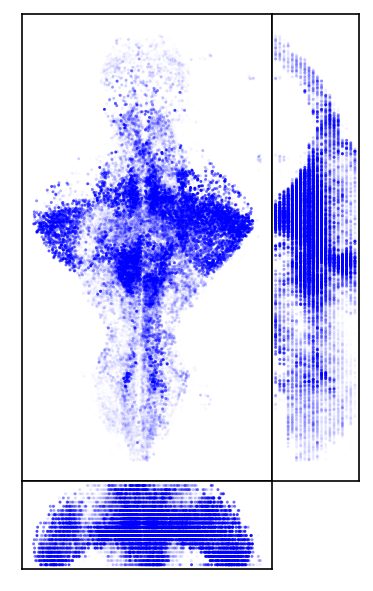

In [53]:
#⌨️⬇️
plot_brain_projections(coords,r2**2)

And the histogram of $R^2$ values:

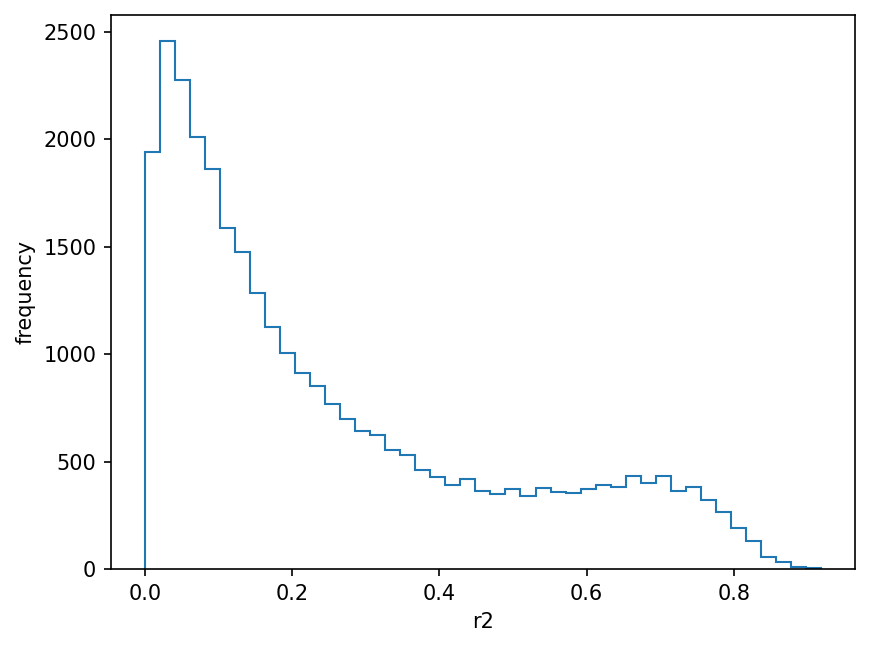

In [54]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(r2,bins='auto',histtype='step')
ax.set_xlabel('r2')
ax.set_ylabel('frequency')
plt.show()

Now we would like to find the neurons whose activity is well fitted by our linear model.  To find the $R^2$ values that are significantly different from zero we can again use the stationary bootstrap to create new samples of brain activity with a scrambled temporal structure and see how our model performs.

Be careful about the shape of the input for the function `stationary_bootstrap`.

In [55]:
#⌨️⬇️
n_resamples=50
r2_sbs=np.zeros(n_resamples*n_neurons) 

for i in tqdm(range(n_resamples)):
    dff_resampled=stationary_bootstrap(dff.T).T
    reg=LinearRegression().fit(regressors.T,dff_resampled.T)
    r2_sbs[i*n_neurons:(i+1)*n_neurons]=r2_score(dff_resampled.T,reg.predict(regressors.T),multioutput='raw_values')

100%|███████████████████████████████████████████| 50/50 [00:40<00:00,  1.24it/s]


Let's compare the distribution of $R^2$ values with the null distribution obtained by bootstrapping:

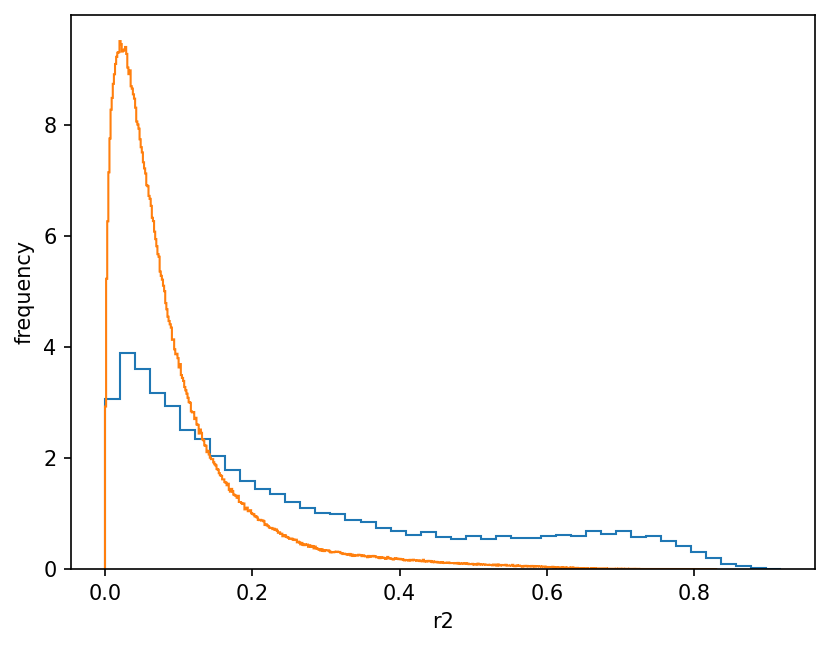

In [56]:
#⌨️⬇️
i=0
fig,ax=plt.subplots()
ax.hist(r2,bins='auto',histtype='step',density=True)
ax.hist(r2_sbs,bins='auto',histtype='step',density=True)
ax.set_xlabel('r2')
ax.set_ylabel('frequency')
plt.show()

We use the Benjamini–Hochberg procedure once again to find the neurons for which $R^2$ is significantly larger than 0: 

In [57]:
#⌨️⬇️
indices_r2,mask_r2=find_significant_neurons(r2,r2_sbs)
len(indices_r2)

5982

We can look again at the value of the coefficients, but now just for the neurons for which the linear fit is significant:

In [58]:
#⌨️⬇️
plot_coefficients(coords,coef,mask_r2)

interactive(children=(IntSlider(value=0, description='regressor', max=2), Output()), _dom_classes=('widget-int…

### Analyze which regressor are important in fitting the activity of each neuron:

Now, we would like to find which combination of regressors is important for fitting the activity of each one of these neurons.

We can estimate the uncertainties on the regression coefficient by using again a bootstrap method.
This time we create new sets of (regressors,fluorescences) values by resampling them with replacement, here we don't care about preserving short term temporal structure in the data as we're keeping together values of regressors and fluorescences that correspond to the same time point. Therefore we don't have to use the stationary bootstrap, but a simple resampling.
Then we can perform linear regression again on each of these resampled sets to obtain new estimates of the coefficients.
Finally we can calculate the standard error of the coefficients as the sample standard deviation of the bootstrapped coefficient values

We first define a function that takes a signal and resamples it with replacement to obtain the resampled_signalbootstrapped signal:

In [59]:
def bootstrap(signal):
    """resample a time series with replacement.

    Parameters :
    ------------
    signal : array
        original time series, the first dimension corresponds to time, shape (n_timepoints,...)
        
    Return :
    --------
    resampled_signal : array
        bootstrapped time series
    """
    #⌨️⬇️
    l=len(signal)
    random_indices=np.random.randint(l,size=l)
    resampled_signal=signal[random_indices]
    return resampled_signal

Then we have to create new sets of (regressors,fluorescences) samples and get the best fit coefficients for each of them:

In [60]:
#⌨️⬇️
n_resamples=100
coef_bs=np.zeros((n_resamples,n_neurons,n_regressors))
samples=np.concatenate([regressors,dff])

for n in tqdm(range(n_resamples)):
    resampled=bootstrap(samples.T).T
    reg=LinearRegression().fit(resampled[:n_regressors].T,resampled[n_regressors:].T)
    coef_bs[n]=reg.coef_

100%|█████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


Finally we can estimate the standard error for each coefficient by evaluating the standard deviation of the bootstrapped samples, you can include a corrective factor of $\sqrt{n/(n-1)}$ where $n$ is the number of bootstrapped samples:

In [61]:
#⌨️⬇️
coef_se=np.zeros_like(coef)
for i in range(n_neurons):
    coef_se[i]=np.sqrt(n_resamples/(n_resamples-1))*np.std(coef_bs[:,i,:],axis=0,ddof=1)

We can plot the distributions of bootstrapped coefficients for a given neuron together with the actual value of the coefficients:

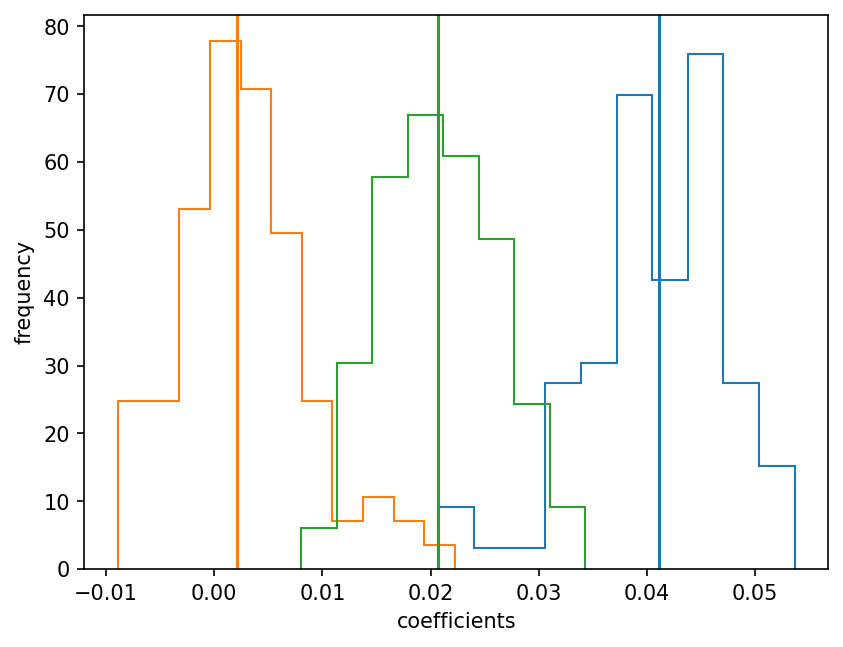

In [62]:
i=100

colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
fig,ax=plt.subplots()
for r in range(n_regressors):
    ax.hist(coef_bs[:,i,r],bins='auto',histtype='step',density=True,color=colors[r])
    ax.axvline(coef[i,r],color=colors[r])

ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

And have a look at the distributions of standard errors:

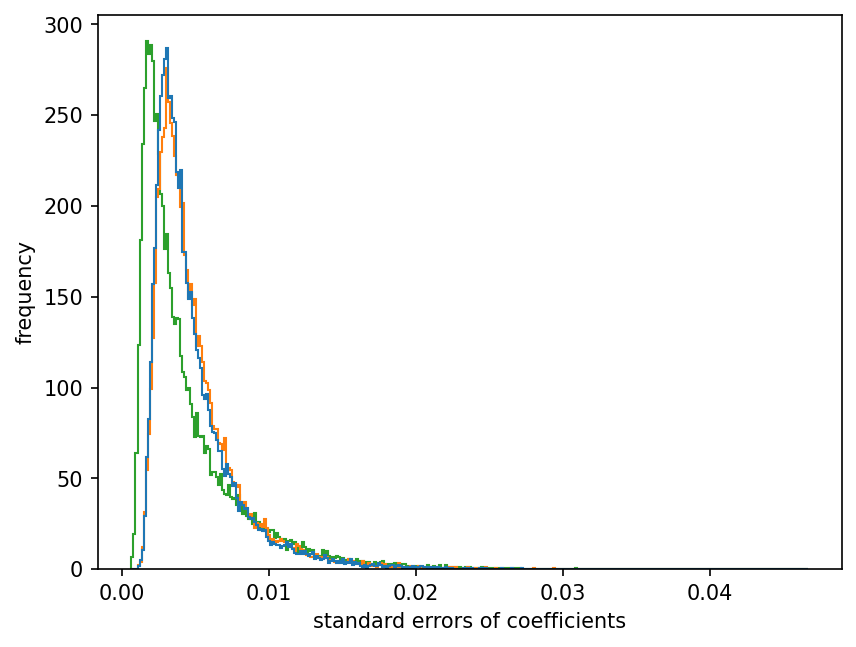

In [63]:
fig,ax=plt.subplots()
ax.hist(coef_se,bins='auto',histtype='step',density=True)
ax.set_xlabel('standard errors of coefficients')
ax.set_ylabel('frequency')
plt.show()

Now we'll create a label for each neuron in order to summarize the results of the multiple linear regression. For each regressor we assign $0$ if the corresponding coefficient is not significantly different from 0 (by comparing it with its standard error). For coefficients that are significantly different from 0 we assign $1$ if the coefficient is positive and $-1$ if it's negative.

We say that a coefficient is significantly different from zero if it's further than zero by 2 times its standard error or more.

In [64]:
#⌨️⬇️
neuron_labels=np.zeros_like(coef)
for i in range(n_regressors): #loop over all regressors
    neuron_labels[coef[:,i]>2*coef_se[:,i],i]=1 #if the coefficients are larger than 2*SE we set the sign to 1
    neuron_labels[coef[:,i]<-2*coef_se[:,i],i]=-1 #if they are smaller than -2*SE we set it to -1
neuron_labels=neuron_labels[indices_r2] #we only consider the neurons for which the fit is good

Then we can group the neurons using these labels and look at the frequency of each combination in the brain.

We can get all possible combinations using `itertools.product`, and then count how many neurons are there for each combination: 

In [65]:
#⌨️⬇️
all_possible_labels=list(itertools.product([0,1,-1],repeat=n_regressors)) #get all possible combinations of 0, 1 and -1
n_neurons_per_label=[]
text_labels=[]
for label in all_possible_labels:
    n_neurons_per_label.append(np.sum(np.all(neuron_labels==label,axis=1))) #number of neurons with a certain label
    text_labels.append(str(label)) #each label saved as a string
n_neurons_per_label=np.array(n_neurons_per_label)
text_labels=np.array(text_labels)

Now we can visualize the number of neurons with each label with a bar graph:

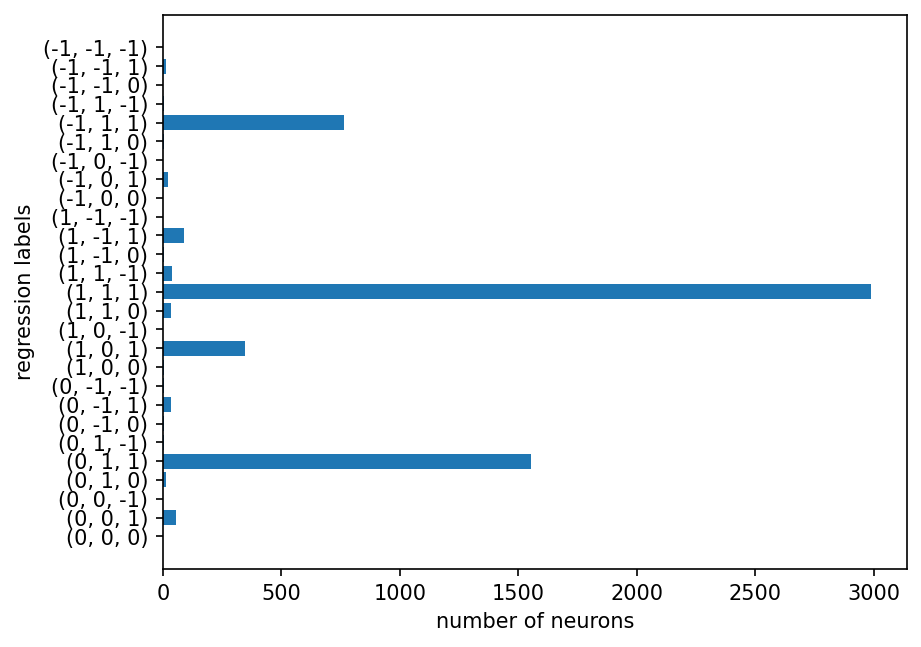

In [66]:
min_n_neurons=0
fig,ax=plt.subplots()
ax.barh(text_labels[n_neurons_per_label>=min_n_neurons],n_neurons_per_label[n_neurons_per_label>=min_n_neurons])
ax.set_xlabel('number of neurons')
ax.set_ylabel('regression labels')
plt.show()

We can also order the labels with increasing number of neurons for clarity:

In [67]:
#⌨️⬇️
sorted_indices=np.argsort(n_neurons_per_label)
text_labels_sorted=text_labels[sorted_indices]
n_neurons_per_label_sorted=n_neurons_per_label[sorted_indices]

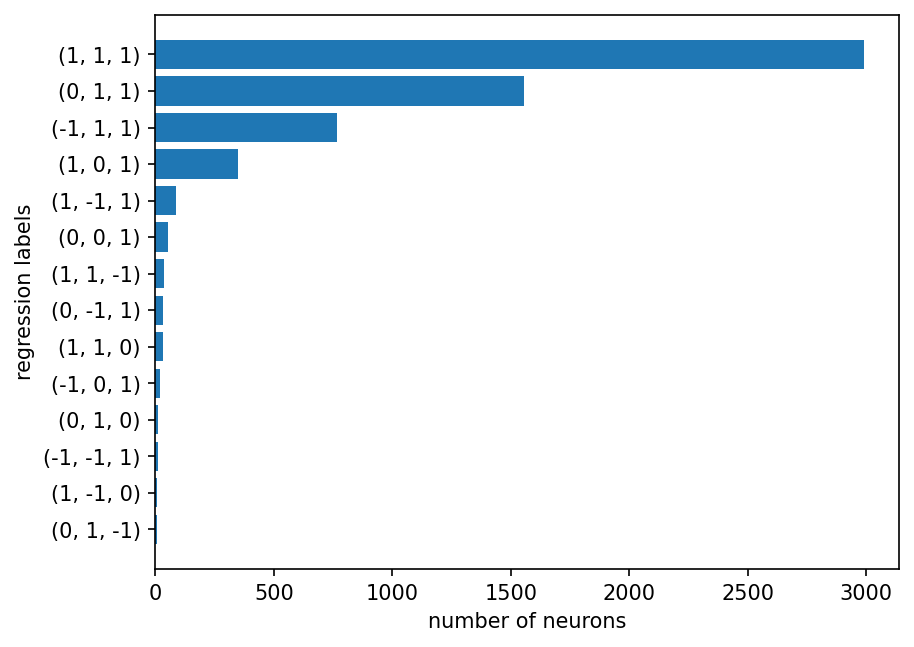

In [68]:
min_n_neurons=5
fig,ax=plt.subplots()
ax.barh(text_labels_sorted[n_neurons_per_label_sorted>=min_n_neurons],n_neurons_per_label_sorted[n_neurons_per_label_sorted>=min_n_neurons])
ax.set_xlabel('number of neurons')
ax.set_ylabel('regression labels')
plt.show()

Now for each combination we can plot the position of the neurons with that label in the brain and their average activity:

In [69]:
#⌨️⬇️
plot_neurons_per_label(neuron_labels,indices_r2,r2,coords,regressors,dff,brain_times)

interactive(children=(Text(value='(1, 1, 1)', description='label'), Output()), _dom_classes=('widget-interact'…

Have to look at the position of neurons with different labels, are they spatially organized?

What about their average activities? Are they as you expected them?

Are there some neuron with labels that you wouldn't have expected?

We can also look at the activity of each individual neuron with a particular label:

In [70]:
#⌨️⬇️
label=(0,-1,1)
indices_label=indices_r2[np.all(neuron_labels==label,axis=1)]
plot_dff_traces(regressors.T,brain_times,indices_label,dff)

interactive(children=(IntSlider(value=0, description='neuron', max=33), Output()), _dom_classes=('widget-inter…

### Other regressors:

If you have some time you can try to perform multiple linear regression with other combinations of regressors.
Otherwise let's move directly to the last section.

For example we can define two regressors related to left and right tail movements.  The signal `side_thrust` is a measure of the strength of the tail movement towards the left and the right, positive values indicate thrust towards the left, while negative ones towards the right.

We can generate two regressors by separating it into a signal with the swimming strength towards the left and one towards the right:

In [71]:
#⌨️⬇️
left_thrust=np.copy(side_thrust)
left_thrust[left_thrust<0]=0
signal_left=convolve_and_interpolate(left_thrust,tail_times,brain_times)

right_thrust=-np.copy(side_thrust)
right_thrust[right_thrust<0]=0
signal_right=convolve_and_interpolate(right_thrust,tail_times,brain_times)

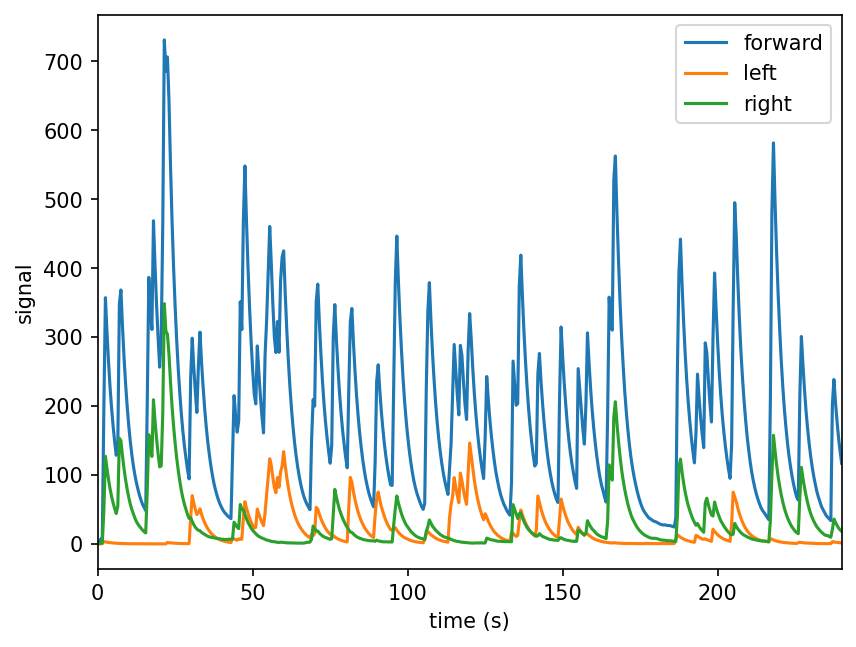

In [72]:
#⌨️⬇️
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
ax.plot(brain_times,signal_forward,label='forward')
ax.plot(brain_times,signal_left,label='left')
ax.plot(brain_times,signal_right,label='right')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

Then you can simply rerun the cells in this section with a different choice for the `regressors` array.

## Decoding:

We've seen how to model the activity of single neurons as a combination of external signals.

Now we want to explore how to decode external signal from the activity of the whole brain.

We'll try to apply again linear regression but this time we'll be using the activity of all neurons as regressors to try and estimate an external signal.

### Fit a target signal using the neural activities as regressors:

Try to perform a regression using `stimulus_T` as the target signal:

In [73]:
#⌨️⬇️
model=LinearRegression().fit(dff.T,stimulus_T)
coef=model.coef_

Let's look at the $R^2$ coefficient for the fit:

In [74]:
#⌨️⬇️
r2_score(stimulus_T,model.predict(dff.T))

1.0

Now visualize the target signal together with the prediction from our model:

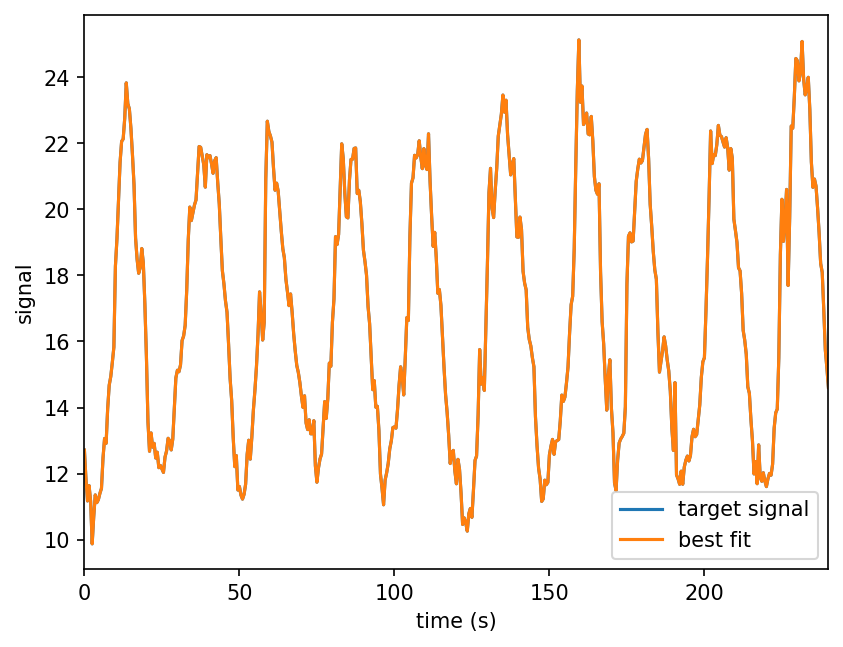

In [75]:
#⌨️⬇️
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
ax.plot(brain_times,stimulus_T,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

Does this result match your expectations?

### Training and test sets:

It's a perfect fit... And it's problematic because we're fitting a signal that doesn't have anything to do with our experiment.

This phenomenon is called overfitting, we're able to fit any kind of signal because we have many more regressors (number of neurons ~ 30000) than data points (number of time points ~ 500). 

In order to test whether our model is good we should use only a part of the data points (training set) to obtain its parameters and then test how it performs on the remaining datapoints that we left out (test set).

Let's try to fit the model on the first 80% of the signal and see how it performs on the remaining 20%.

To create the training and test sets you can slice the original arrays:

In [76]:
#⌨️⬇️
fraction_train=0.8
idx=int(fraction_train*len(brain_times))
X_train=dff.T[:idx]
X_test=dff.T[idx:]
y_train=stimulus_T[:idx]
y_test=stimulus_T[idx:]

Now perform the linear regression on the training set:

In [77]:
#⌨️⬇️
model=LinearRegression().fit(X_train,y_train)
coef=model.coef_

Let's evaluate $R^2$ on the training set:

In [78]:
#⌨️⬇️
r2_score(y_train,model.predict(X_train))

1.0

And on the test set:

In [79]:
#⌨️⬇️
r2_score(y_test,model.predict(X_test))

-0.018586162523314353

And visualize again the target signal together with the prediction:

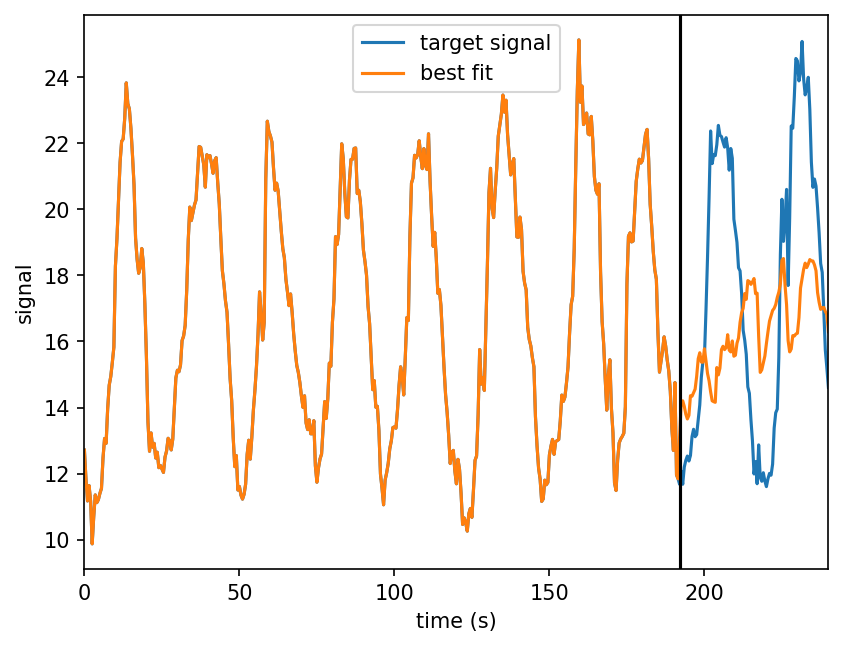

In [80]:
#⌨️⬇️
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
ax.plot(brain_times,stimulus_T,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')
ax.axvline(brain_times[idx],color='k')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

As expected it doesn't work for predicting the second half of the experiment, it's reassuring!

Now let's try to do the same but with a relevant target signal, the strength of the tail movements.  First define the new target values for the training and test sets:

In [81]:
#⌨️⬇️
signal_forward=scale(signal_forward)

y_train=signal_forward[:idx]
y_test=signal_forward[idx:]

Then perform the regression and look at the $R^2$ scores on the two sets:

In [82]:
#⌨️⬇️
model=LinearRegression().fit(X_train,y_train)
coef=model.coef_

In [83]:
#⌨️⬇️
r2_score(y_train,model.predict(X_train))

1.0

In [84]:
#⌨️⬇️
r2_score(y_test,model.predict(X_test))

0.9638422911276058

Let's have a look at the predicted signal:

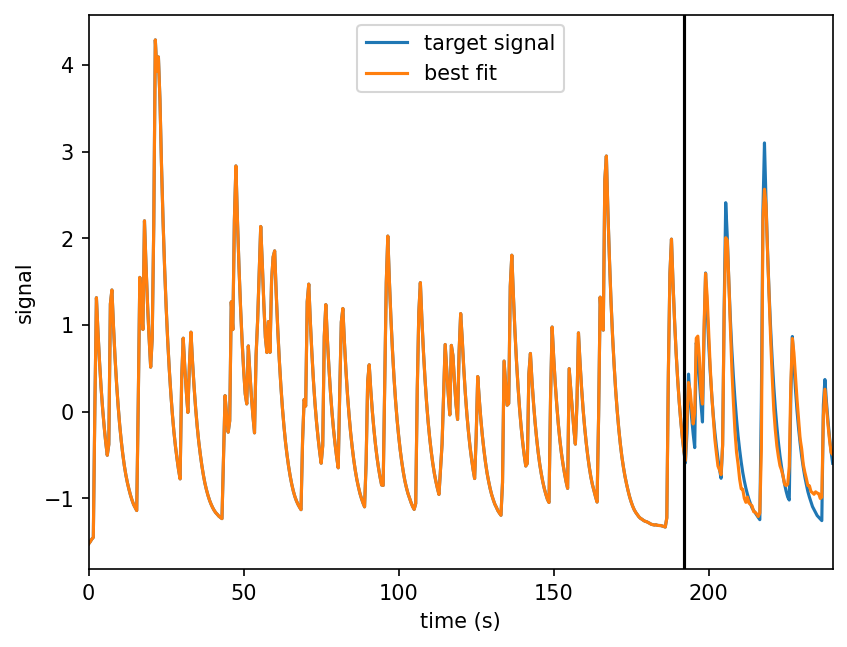

In [85]:
#⌨️⬇️
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
ax.plot(brain_times,signal_forward,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')
ax.axvline(brain_times[idx],color='k')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

It's much better but we're still overfitting the training set, in order to prevent this we'll have to use a technique called regularization.

It consists in adding some constraints on the coefficients in order to reduce the freedom that allows the model to adapt too much to the training set.

In practice we're going to introduce a term in our optimization problem that penalizes large values of the coefficients.
Based on the specific functional form of this term we can have different results, two popular choices are the L2 (ridge) and the L1 (lasso) regulazion, corresponding to the square and the absolute value of the coefficients respectively.

In our case the L1 is a good choice as it forces many coefficient to be exactly zero, and we expect many neurons to be irrelevant in encoding the target signal.

Instead in our current model all neurons contribute to the linear combination, to get an idea we can visualize the distribution of coefficients in the brain:

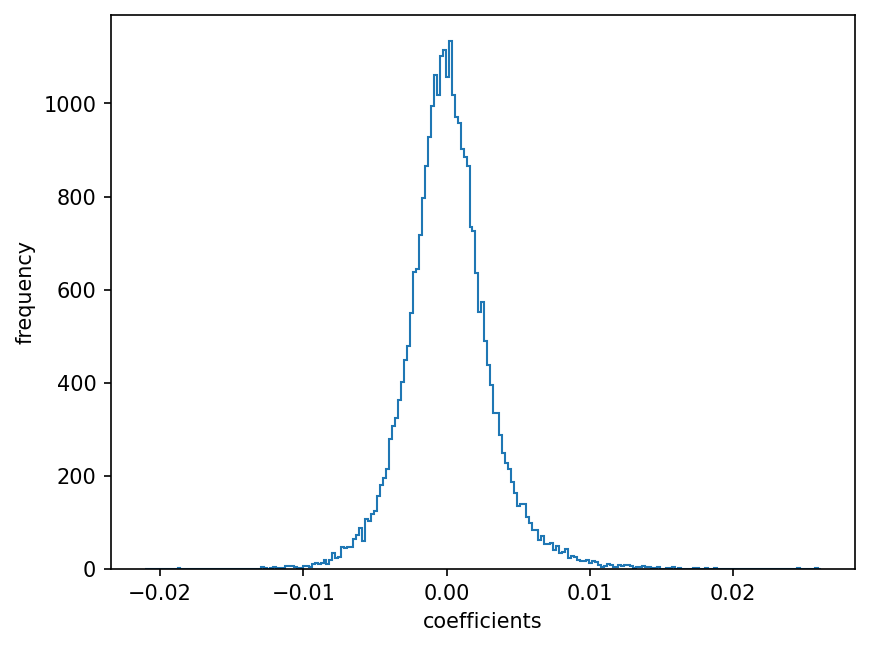

In [86]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(coef,bins='auto',histtype='step')
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

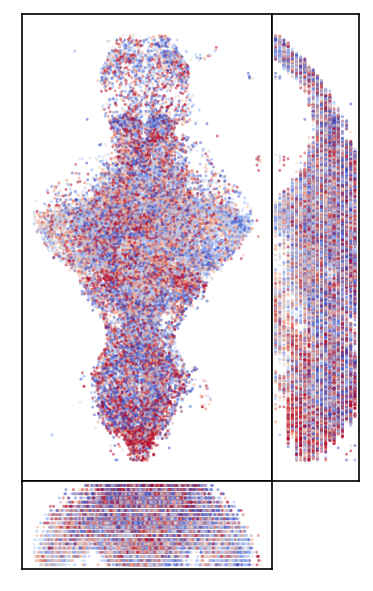

In [87]:
#⌨️⬇️
plot_coefficients(coords,coef)

### L1 regularization:

Adding a regularization means also adding an additional parameter $\alpha$ which tunes the strength of the contraint.

It's usually called a hyperparameter, meaning that it's not obtained from the data but we have to fix it ourselves.

In order to choose a suitable value we can fit several model with different $\alpha$s and then choose the one that performs better.

It would be cheating to use the test set to decide the best value of $\alpha$, as we're using the test set to decide the performance of our model.

Therefore we're going to divide our training set further in two and create a validation set on which we can evaluate the model for different values of $\alpha$s.


In [88]:
#⌨️⬇️
fraction_valid=0.2
idx=int((1-fraction_valid)*len(y_train))

X_train_alpha=X_train[:idx]
X_valid_alpha=X_train[idx:]
y_train_alpha=y_train[:idx]
y_valid_alpha=y_train[idx:]

Now we can loop over some values of $\alpha$ (we choose them logarithmically spaced to check over many different order of magnitude) and fit a linear model with L1 regularization for each value of $\alpha$.  You can use the class `Lasso` from sklearn.  You might have to reduce the tolerance `tol` and increase the maximum number of iterations `max_iter` for the optimization to converge.  Let's save the $R^2$ scores on the validation set and the number of non-zero coefficients:

In [89]:
#⌨️⬇️
alphas=np.logspace(-5,-1,10)
r2s_valid=np.zeros_like(alphas)
n_nonzeros=np.zeros_like(alphas)

for i in tqdm(range(len(alphas))):
    model=Lasso(alpha=alphas[i],max_iter=10000,tol=1e-3).fit(X_train_alpha,y_train_alpha)
    r2s_valid[i]=r2_score(y_valid_alpha,model.predict(X_valid_alpha))
    n_nonzeros[i]=(model.coef_!=0).sum()

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.84s/it]


Let's look at the $R^2$ the validation set in order to choose the best value of $\alpha$:

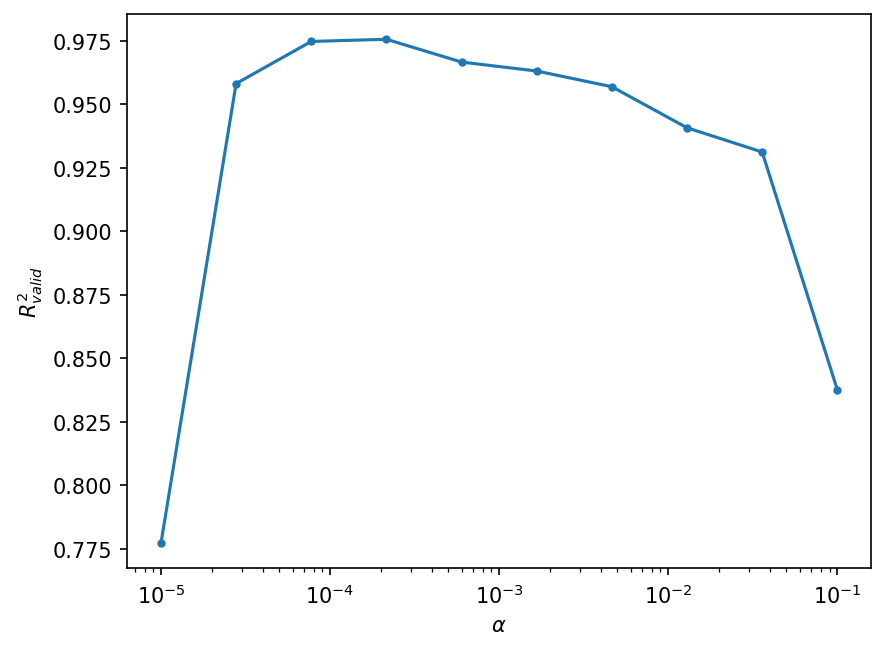

In [90]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.plot(alphas,r2s_valid,'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$R^2_{valid}$')
plt.show()

We can also have a look at the number of non-zero coefficients:

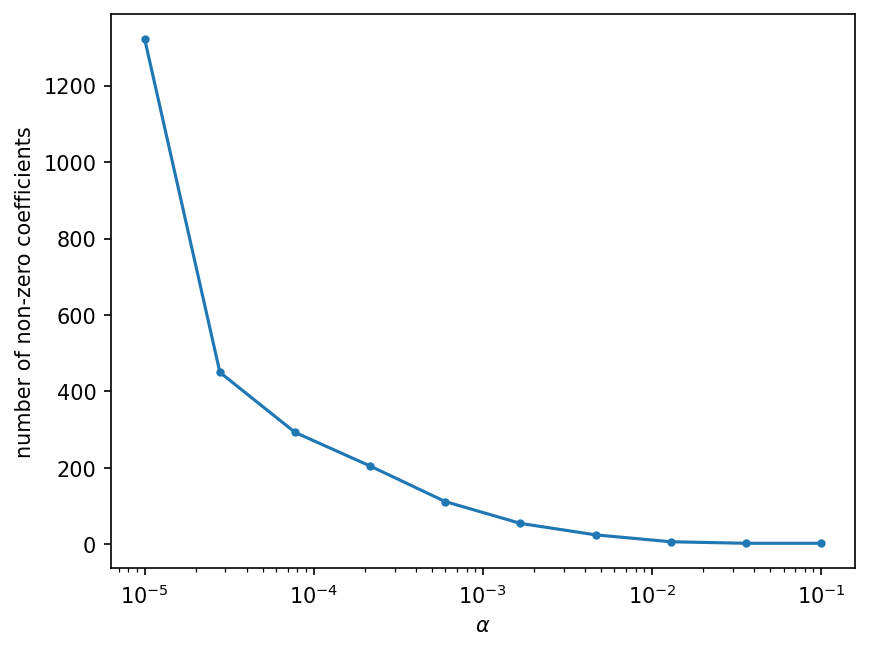

In [91]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.plot(alphas,n_nonzeros,'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('number of non-zero coefficients')
plt.show()

We see that they decrease as the strength of the regularization increases as expected.

Let's extract the best value for $\alpha$:

In [92]:
#⌨️⬇️
best_alpha=alphas[np.argmax(r2s_valid)]
best_alpha

0.00021544346900318823

In [93]:
np.max(r2s_valid)

0.9755952184595631

Now we can finally train our model on the whole training set with our chosen value for $\alpha$ and see how it performs on the test set:

In [94]:
#⌨️⬇️
model=Lasso(alpha=best_alpha,max_iter=10000,tol=1e-3).fit(X_train,y_train)
coef=model.coef_

In [95]:
r2_score(y_train,model.predict(X_train))

0.9983140787235957

In [96]:
r2_score(y_test,model.predict(X_test))

0.9691522107348454

And have a look at the predicted signal:

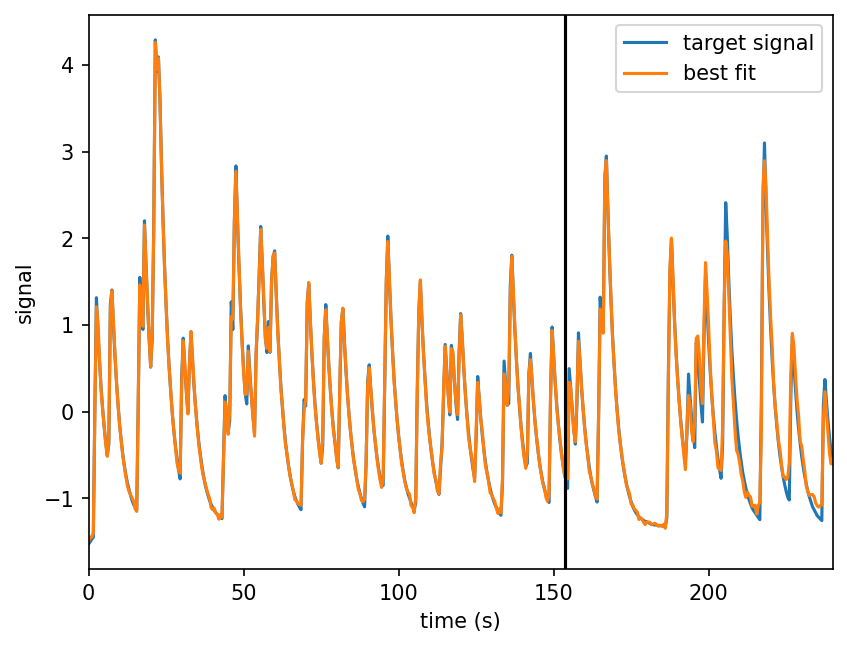

In [97]:
#⌨️⬇️
t1=0
t2=brain_times[-1]

fig,ax=plt.subplots()
ax.plot(brain_times,signal_forward,label='target signal')
ax.plot(brain_times,model.predict(dff.T),label='best fit')
ax.axvline(brain_times[idx],color='k')

ax.set_xlim(t1,t2)
ax.set_xlabel('time (s)')
ax.set_ylabel('signal')
ax.legend()
plt.show()

And finally we can look at the distribution of the coefficients in the brain:

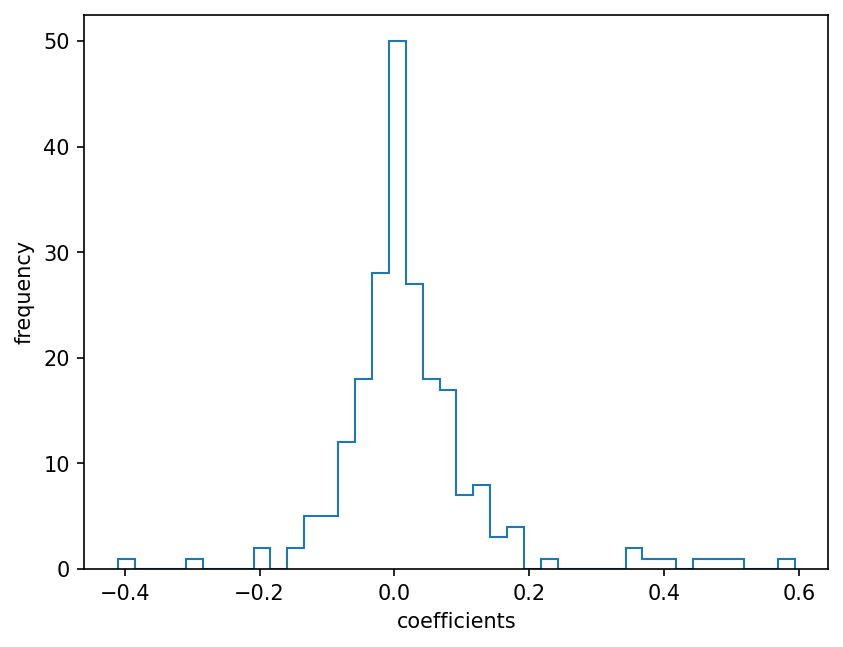

In [98]:
#⌨️⬇️
fig,ax=plt.subplots()
ax.hist(coef[coef!=0],bins='auto',histtype='step')
ax.set_xlabel('coefficients')
ax.set_ylabel('frequency')
plt.show()

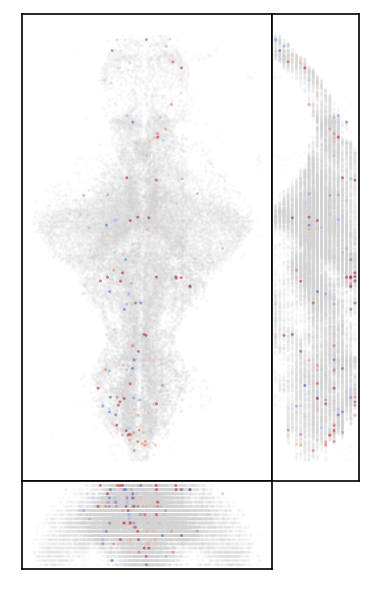

In [99]:
#⌨️⬇️
mask=np.zeros(len(dff))
mask[coef!=0]=1
mask=mask.astype(bool)

plot_coefficients(coords,coef,mask)

We see that while the score on the training set decreased we have actually obtained a better score on the test set by using regularization.

More importantly we see that most of the neurons are not necessary in decoding the target signal.

What is the meaning of neurons with negative coefficients?  You can try to plot their fluorescence traces.
You can also try to perform a regression with the additional constraint of only positive coefficient by changing the parameter `positive`.  What changes in the results?

If you still have more time you try using L2 regularization and see what changes.  You can use the class `Ridge` from sklearn.